#### PyMC3概率编程基础知识

In [1]:
import pymc3 as pm

with pm.Model() as model:
    parameter = pm.Exponential("poisson_param", 1)
    data_generator = pm.Poisson("data_generator", parameter)

In [2]:
with model:
    data_plus_one = data_generator + 1

In [3]:
parameter.tag.test_value

array(0.69314718)

In [4]:
with pm.Model() as model:
    theta = pm.Exponential("theta", 2)
    data_generator = pm.Poisson("data_generator", theta)

In [5]:
with pm.Model() as ab_testing:
    p_A = pm.Uniform("P(A)", 0, 1)
    p_B = pm.Uniform("P(B)", 0, 1)

#### PyMC3的变量

In [20]:
print("parameter.tag.test_value =", parameter.tag.test_value)
print("data_generator.tag.test_value =", data_generator.tag.test_value)
print("data_plus_one.tag.test_value =", data_plus_one.tag.test_value)

parameter.tag.test_value = 0.6931471824645996
data_generator.tag.test_value = 0
data_plus_one.tag.test_value = 1


In [21]:
with pm.Model() as model:
    parameter = pm.Exponential("poisson_param", 1, testval=0.5)

print("\nparameter.tag.test_value =", parameter.tag.test_value)


parameter.tag.test_value = 0.5


In [7]:
with pm.Model() as model:
    lambda_1 = pm.Exponential("lambda_1", 1)
    lambda_2 = pm.Exponential("lambda_2", 1)
    tau = pm.DiscreteUniform("tau", lower=0, upper=10)

new_deterministic_variable = lambda_1 + lambda_2

In [13]:
import numpy as np
import scipy.stats as stats

n_data_points = 5  # in CH1 we had ~70 data points
idx = np.arange(n_data_points)
with model:
    lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)

In [9]:
import theano.tensor as tt

with pm.Model() as theano_test:
    p1 = pm.Uniform("p", 0, 1)
    p2 = 1 - p1
    p = tt.stack([p1, p2])
    
    assignment = pm.Categorical("assignment", p)

#### 人工生成模拟数据（同样的故事，不同的结果）

In [10]:
tau = np.random.randint(0, 80)
print(tau)

37


In [11]:
alpha = 1./20.
lambda_1, lambda_2 = np.random.exponential(scale=1/alpha, size=2)
print(lambda_1, lambda_2)

11.635415750503642 6.092784742464148


In [14]:
data = np.r_[stats.poisson.rvs(mu=lambda_1, size=tau), stats.poisson.rvs(mu=lambda_2, size = 80 - tau)]

In [6]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt

plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
figsize(12.5, 4)

In [ ]:
plt.bar(np.arange(80), data, color="#348ABD")
plt.bar(tau-1, data[tau - 1], color="r", label="user behaviour changed")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Artificial dataset")
plt.xlim(0, 80)
plt.legend();

#### 一个简单的案例

In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats

In [2]:
# The parameters are the bounds of the Uniform.
with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1)

In [3]:
#set constants
p_true = 0.05  # remember, this is unknown.
N = 1500

# sample N Bernoulli random variables from Ber(0.05).
# each random variable has a 0.05 chance of being a 1.
# this is the data-generation step
occurrences = stats.bernoulli.rvs(p_true, size=N)

print(occurrences) # Remember: Python treats True == 1, and False == 0
print(np.sum(occurrences))

[0 0 1 ... 0 0 0]
70


In [4]:
# Occurrences.mean is equal to n/N.
print("What is the observed frequency in Group A? %.4f" % np.mean(occurrences))
print("Does this equal the true frequency? %s" % (np.mean(occurrences) == p_true))

What is the observed frequency in Group A? 0.0467
Does this equal the true frequency? False


In [5]:
#include the observations, which are Bernoulli
with model:
    obs1 = pm.Bernoulli("obs1", p, observed=occurrences)
    # To be explained in chapter 3
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
    burned_trace = trace[1000:]

/opt/miniconda3/envs/pytorch/lib/python3.6/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p]


Sampling 4 chains for 1_000 tune and 18_000 draw iterations (4_000 + 72_000 draws total) took 9 seconds.
The number of effective samples is smaller than 25% for some parameters.


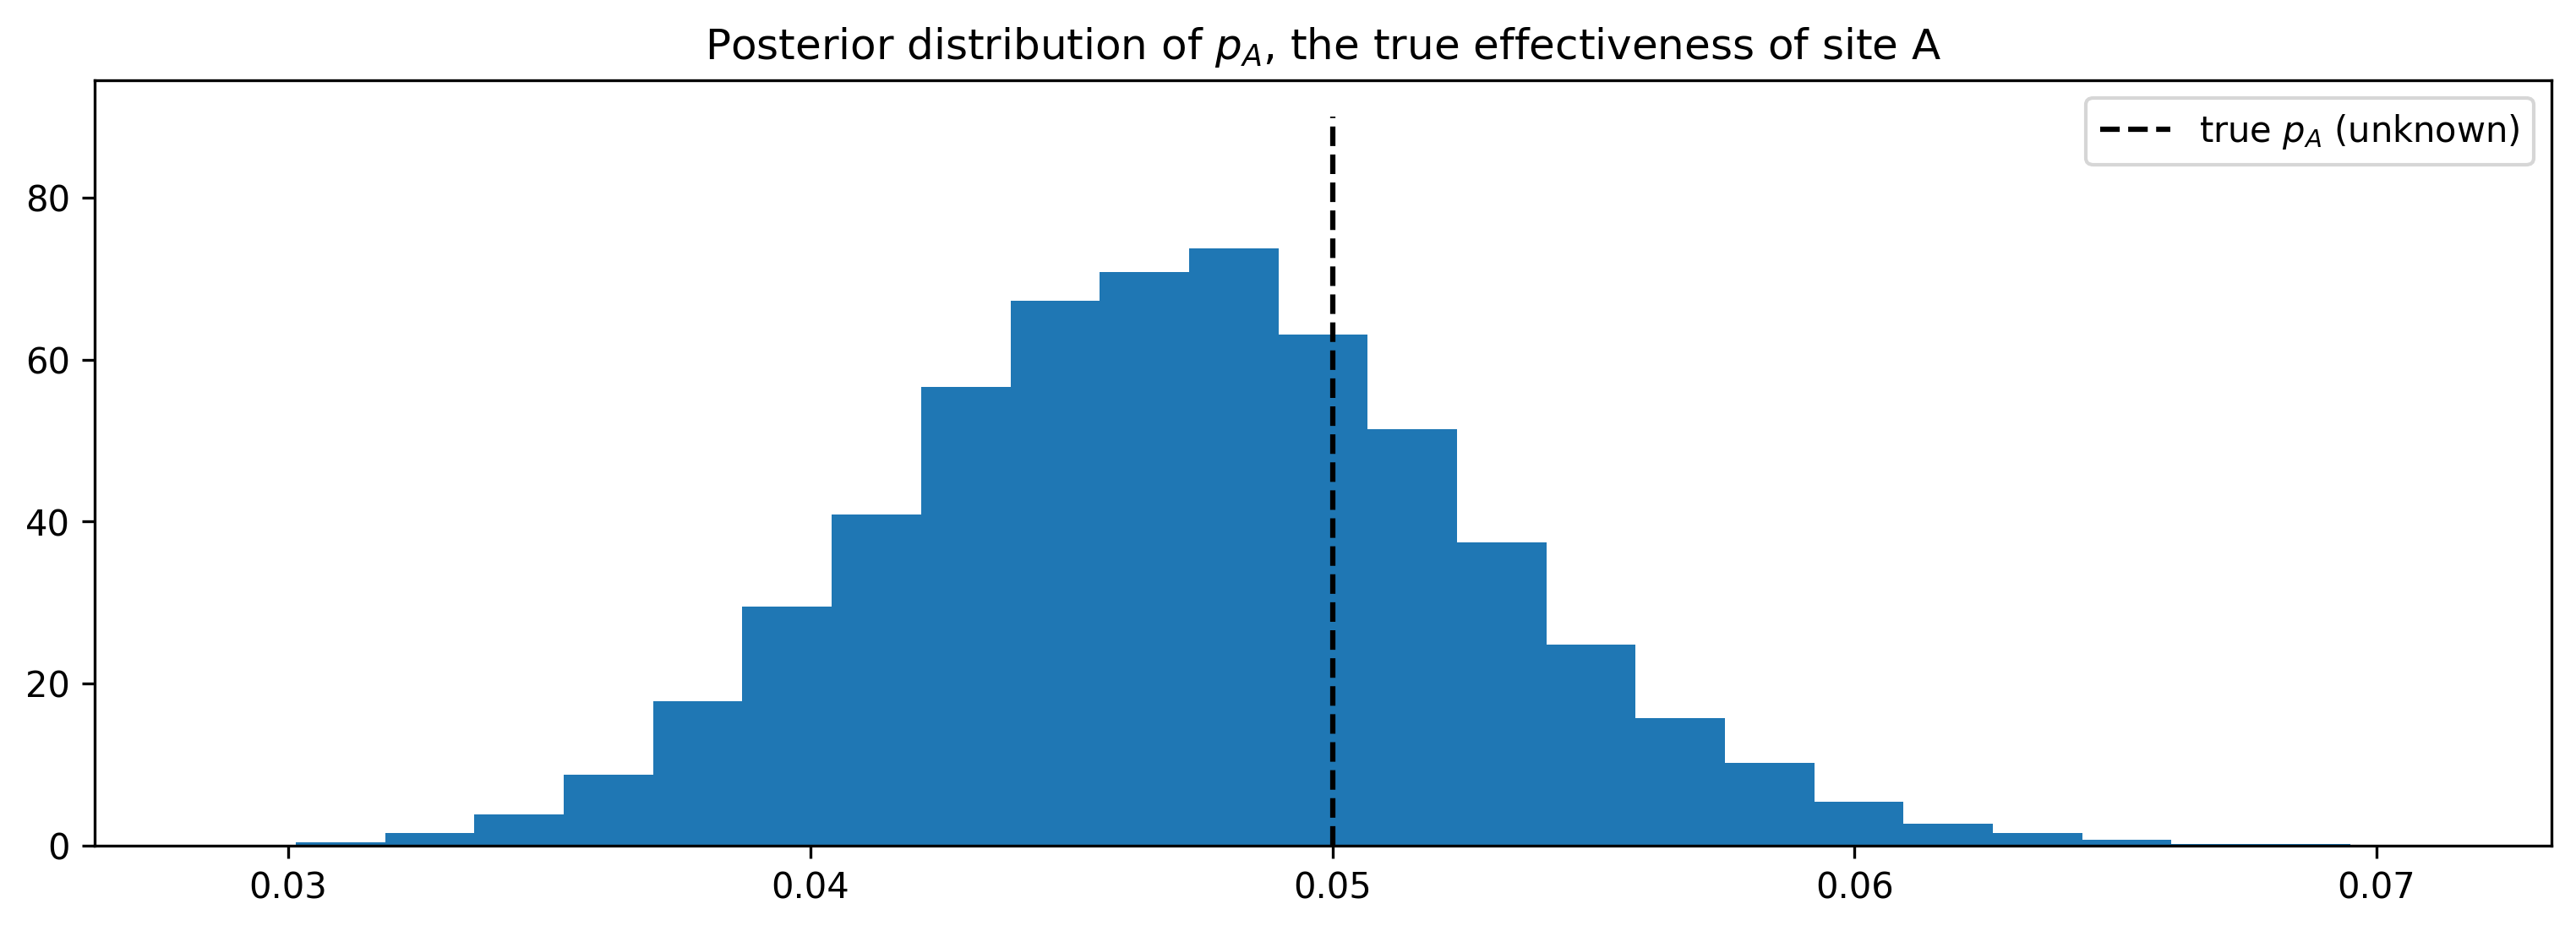

In [7]:
figsize(12.5, 4)
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
plt.hist(burned_trace["p"], bins=25, histtype="stepfilled", density=True)
plt.legend();

#### AB测试

In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats

%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt

plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

In [4]:
import pymc3 as pm
figsize(12, 4)

#these two quantities are unknown to us.
true_p_A = 0.05
true_p_B = 0.04

#notice the unequal sample sizes -- no problem in Bayesian analysis.
N_A = 1500
N_B = 750

#generate some observations
observations_A = stats.bernoulli.rvs(true_p_A, size=N_A)
observations_B = stats.bernoulli.rvs(true_p_B, size=N_B)
print("Obs from Site A: ", observations_A[:30], "...")
print("Obs from Site B: ", observations_B[:30], "...")

Obs from Site A:  [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
Obs from Site B:  [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0] ...


In [5]:
print(np.mean(observations_A))
print(np.mean(observations_B))

0.05533333333333333
0.03866666666666667


In [6]:
# Set up the pymc3 model. Again assume Uniform priors for p_A and p_B.
with pm.Model() as model:
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_A - p_B)

    
    # Set of observations, in this case we have two observation datasets.
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)

    # To be explained in chapter 3.
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)
    burned_trace=trace[1000:]

/opt/anaconda3/envs/pytorch/lib/python3.6/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 21 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [8]:
p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]

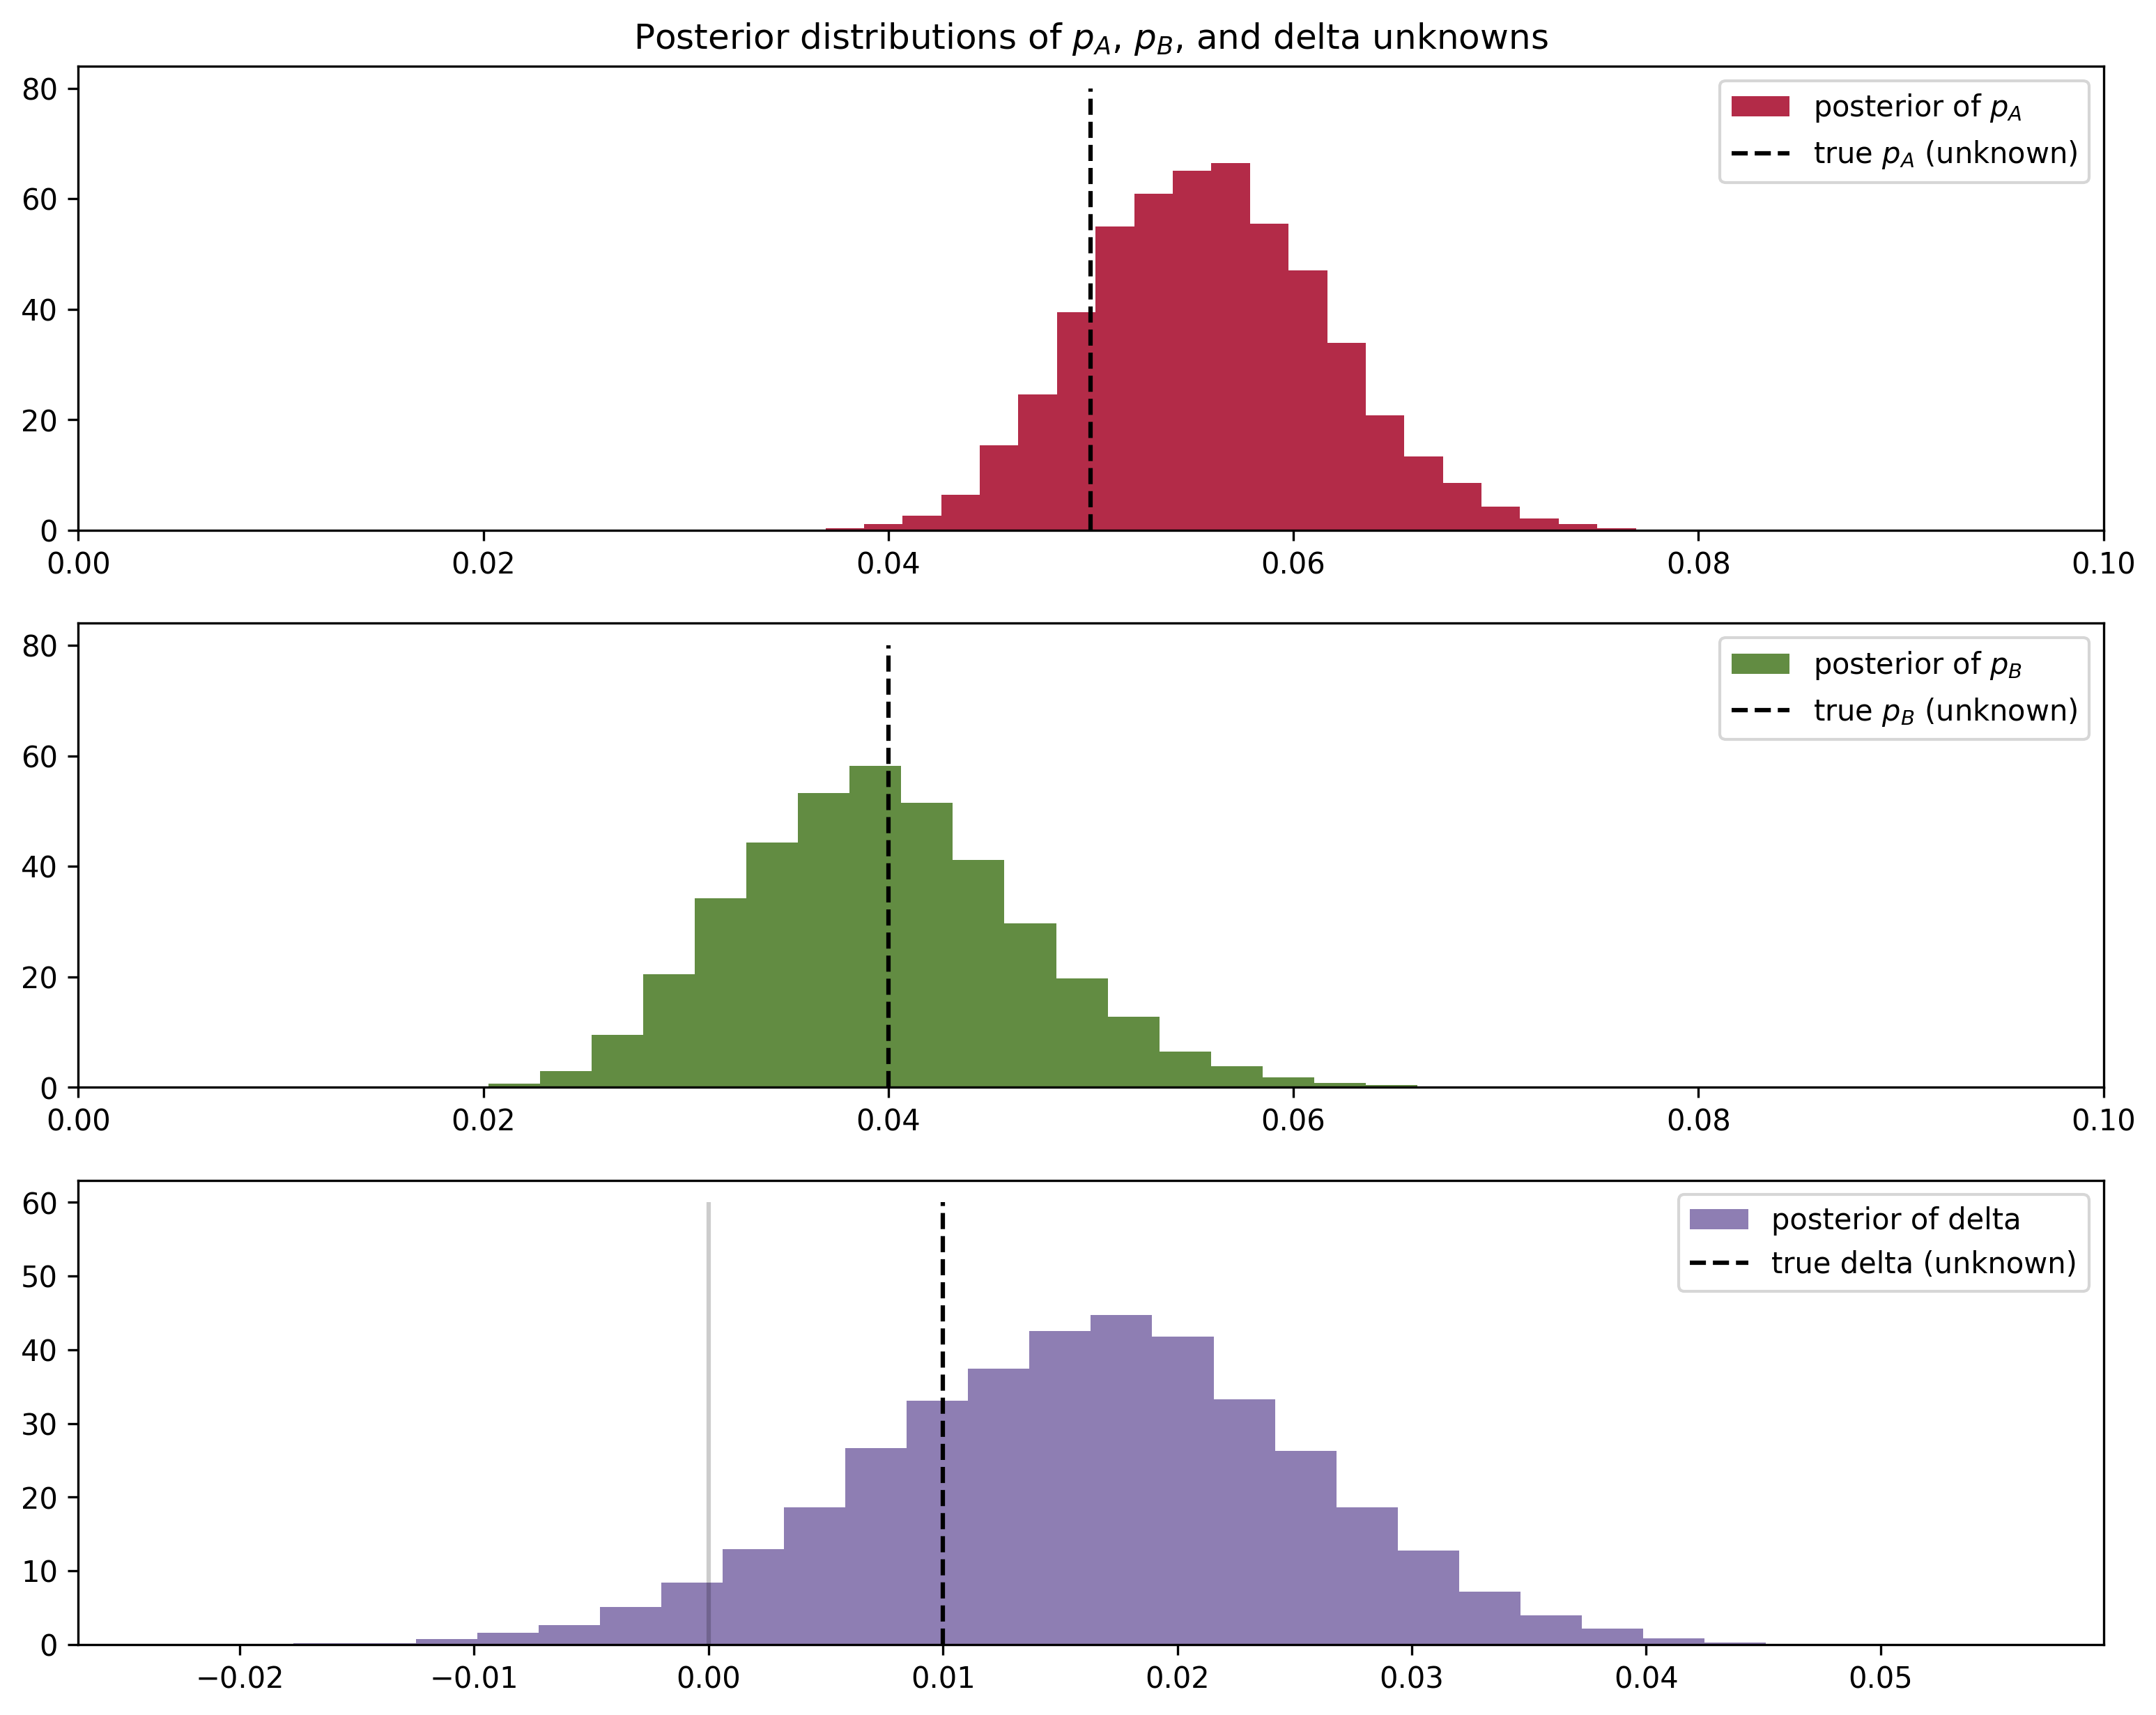

In [10]:
figsize(12.5, 10)

#histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", density=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", density=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", density=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

In [13]:
print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(delta_samples < 0))

print("Probability site A is BETTER than site B: %.3f" % \
    np.mean(delta_samples > 0))

Probability site A is WORSE than site B: 0.043
Probability site A is BETTER than site B: 0.957


#### 挑战者号事故

Temp (F), O-Ring failure?
[[66.  0.]
 [70.  1.]
 [69.  0.]
 [68.  0.]
 [67.  0.]
 [72.  0.]
 [73.  0.]
 [70.  0.]
 [57.  1.]
 [63.  1.]
 [70.  1.]
 [78.  0.]
 [67.  0.]
 [53.  1.]
 [67.  0.]
 [75.  0.]
 [70.  0.]
 [81.  0.]
 [76.  0.]
 [79.  0.]
 [75.  1.]
 [76.  0.]
 [58.  1.]]


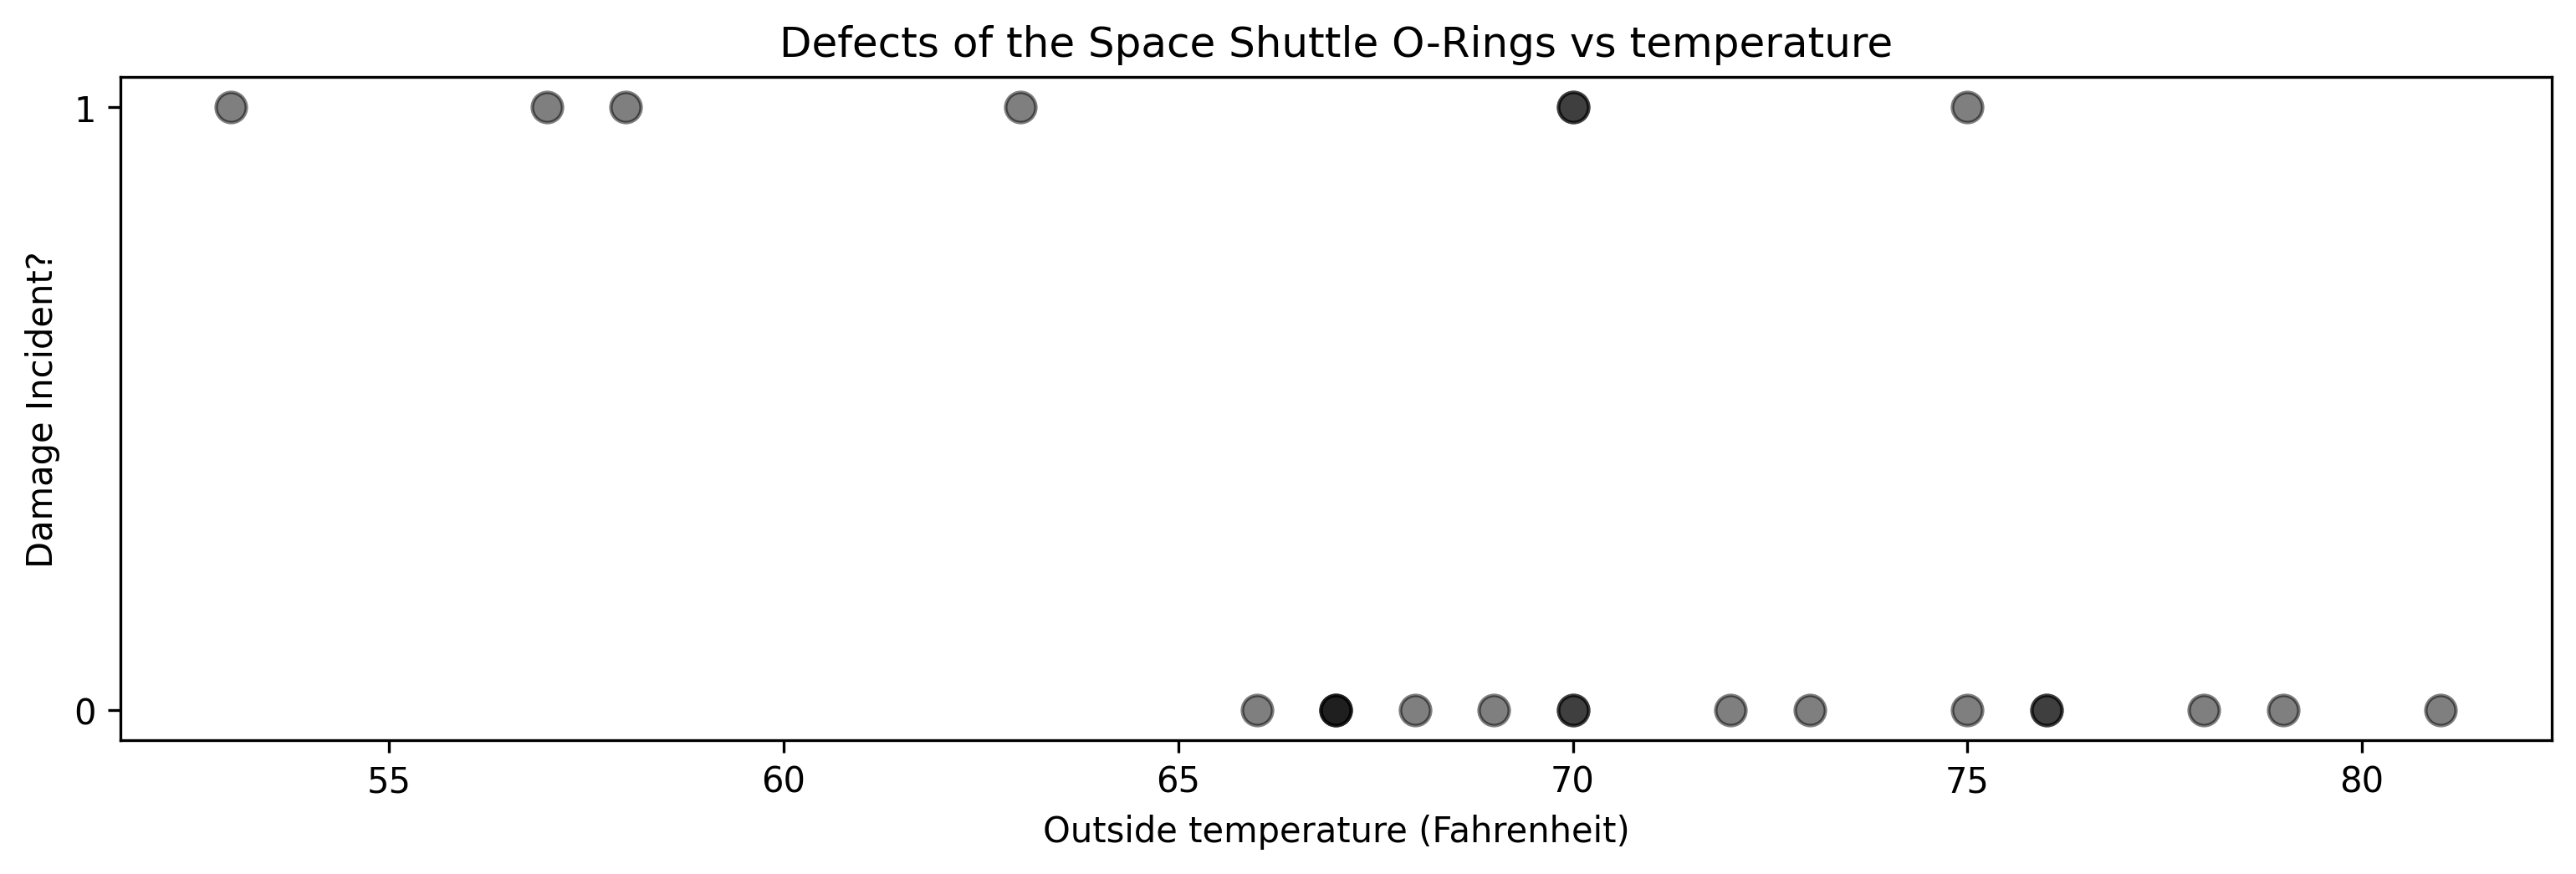

In [8]:
figsize(12.5, 3.5)
np.set_printoptions(precision=3, suppress=True)
challenger_data = np.genfromtxt("data/challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
#drop the NA values
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

#plot it, as a function of tempature (the first column)
print("Temp (F), O-Ring failure?")
print(challenger_data)

plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color="k",
            alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("Damage Incident?")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Defects of the Space Shuttle O-Rings vs temperature");

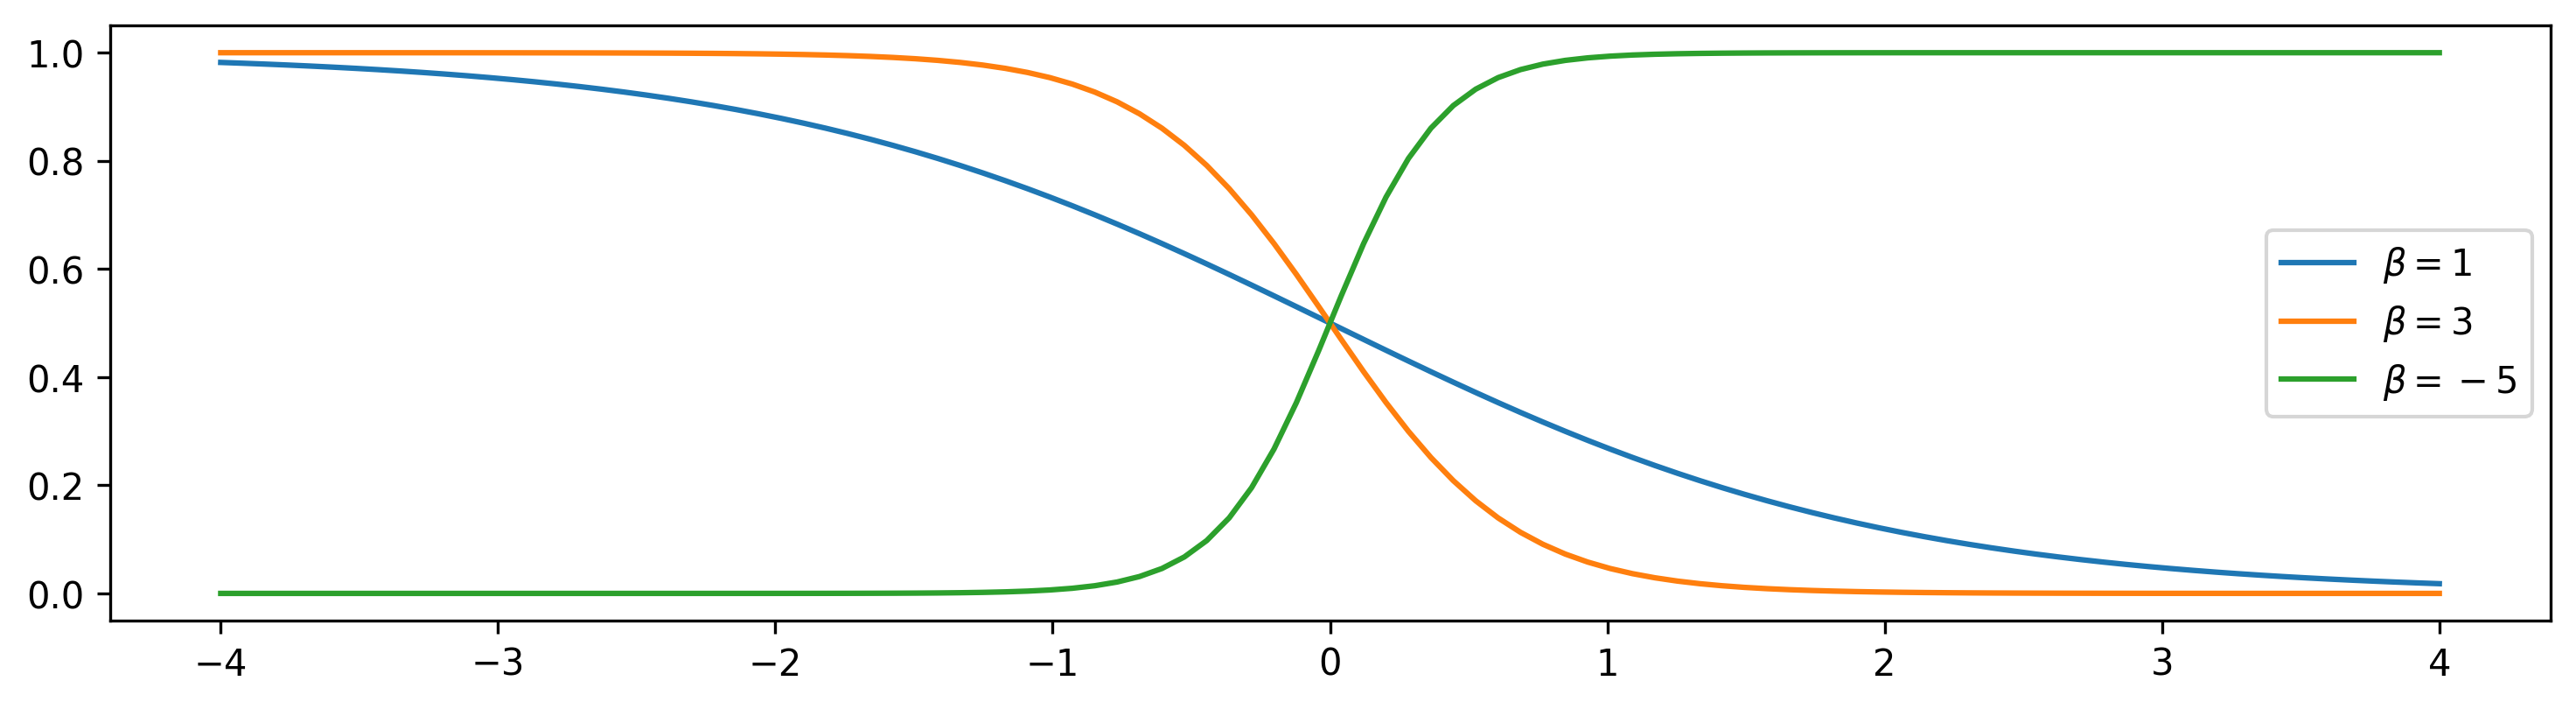

In [9]:
figsize(12, 3)

def logistic(x, beta):
    return 1.0 / (1.0 + np.exp(beta * x))

x = np.linspace(-4, 4, 100)
plt.plot(x, logistic(x, 1), label=r"$\beta = 1$")
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$")
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$")
plt.legend();

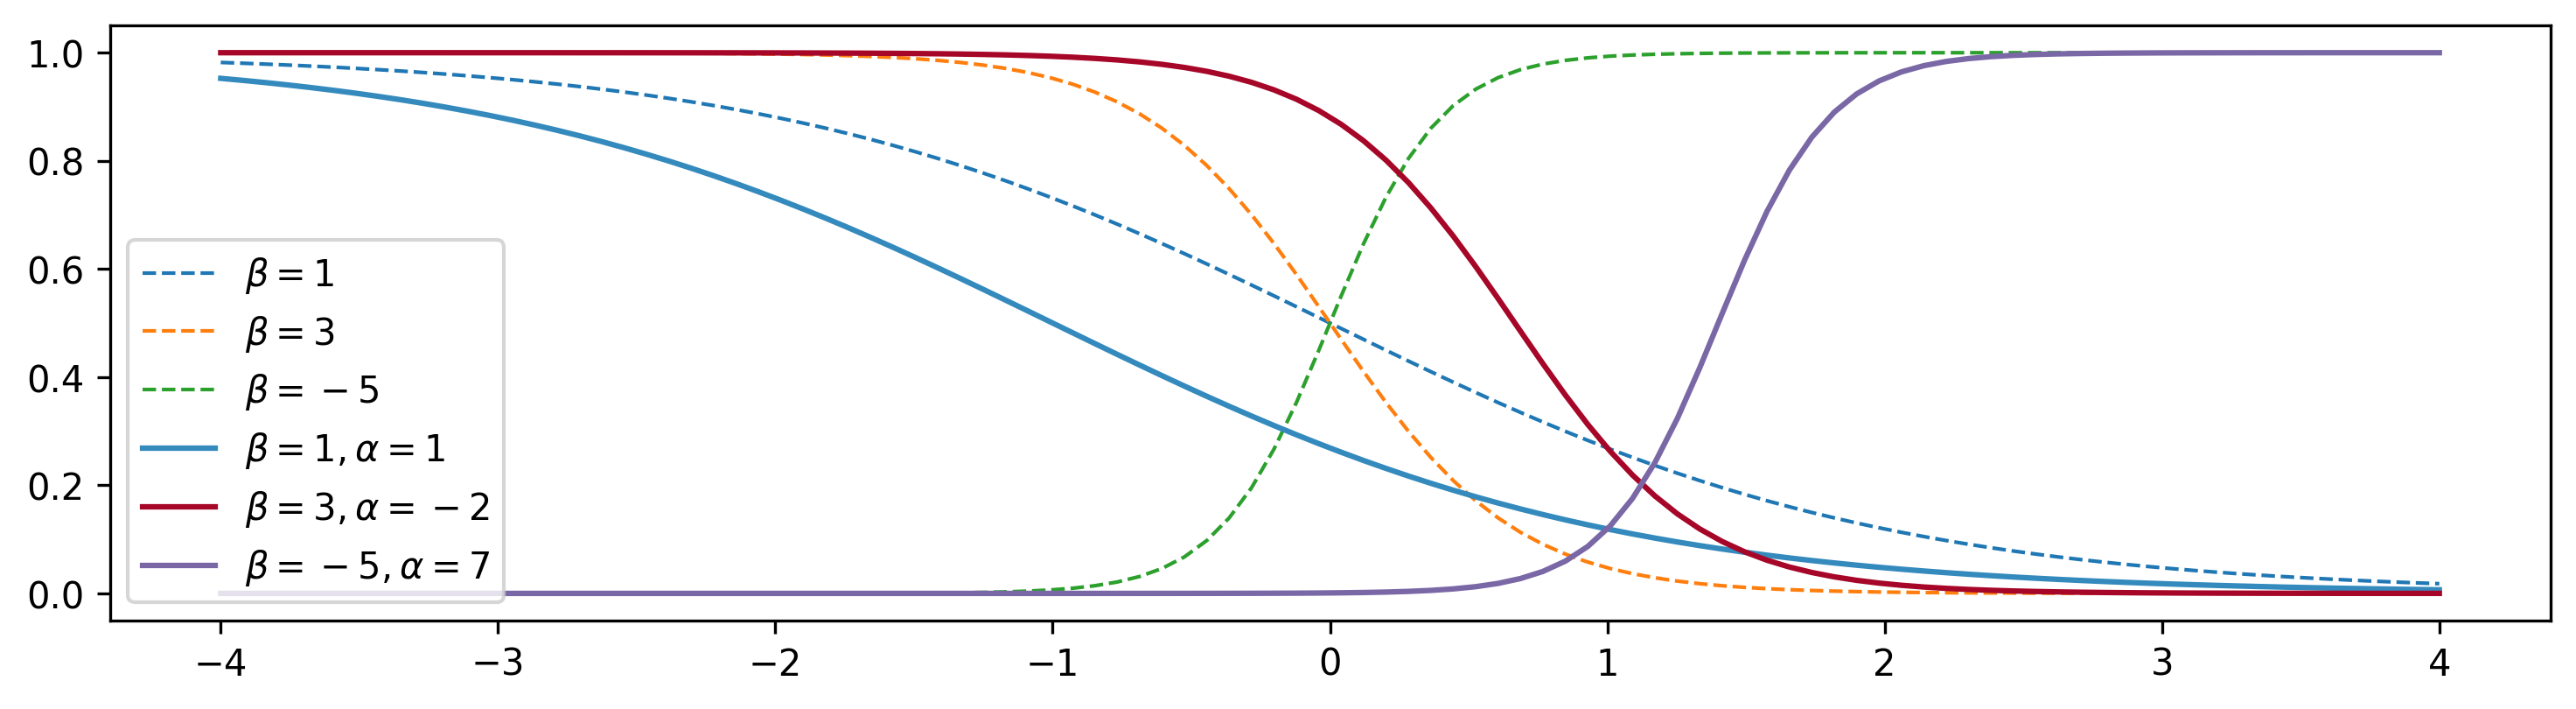

In [10]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

x = np.linspace(-4, 4, 100)

plt.plot(x, logistic(x, 1), label=r"$\beta = 1$", ls="--", lw=1)
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$", ls="--", lw=1)
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$", ls="--", lw=1)

plt.plot(x, logistic(x, 1, 1), label=r"$\beta = 1, \alpha = 1$",
         color="#348ABD")
plt.plot(x, logistic(x, 3, -2), label=r"$\beta = 3, \alpha = -2$",
         color="#A60628")
plt.plot(x, logistic(x, -5, 7), label=r"$\beta = -5, \alpha = 7$",
         color="#7A68A6")

plt.legend(loc="lower left");

In [11]:
import pymc3 as pm
import theano.tensor as tt

temperature = challenger_data[:, 0]
D = challenger_data[:, 1]  # defect or not?

#notice the`value` here. We explain why below.
with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, tau=0.001, testval=0)
    alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*temperature + alpha)))

In [12]:
# connect the probabilities in `p` with our observations through a
# Bernoulli random variable.
with model:
    observed = pm.Bernoulli("bernoulli_obs", p, observed=D)
    
    # Mysterious code to be explained in Chapter 3
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(120000, step=step, start=start)
    burned_trace = trace[100000::2]

/opt/miniconda3/envs/pytorch/lib/python3.6/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]


Sampling 4 chains for 1_000 tune and 120_000 draw iterations (4_000 + 480_000 draws total) took 86 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


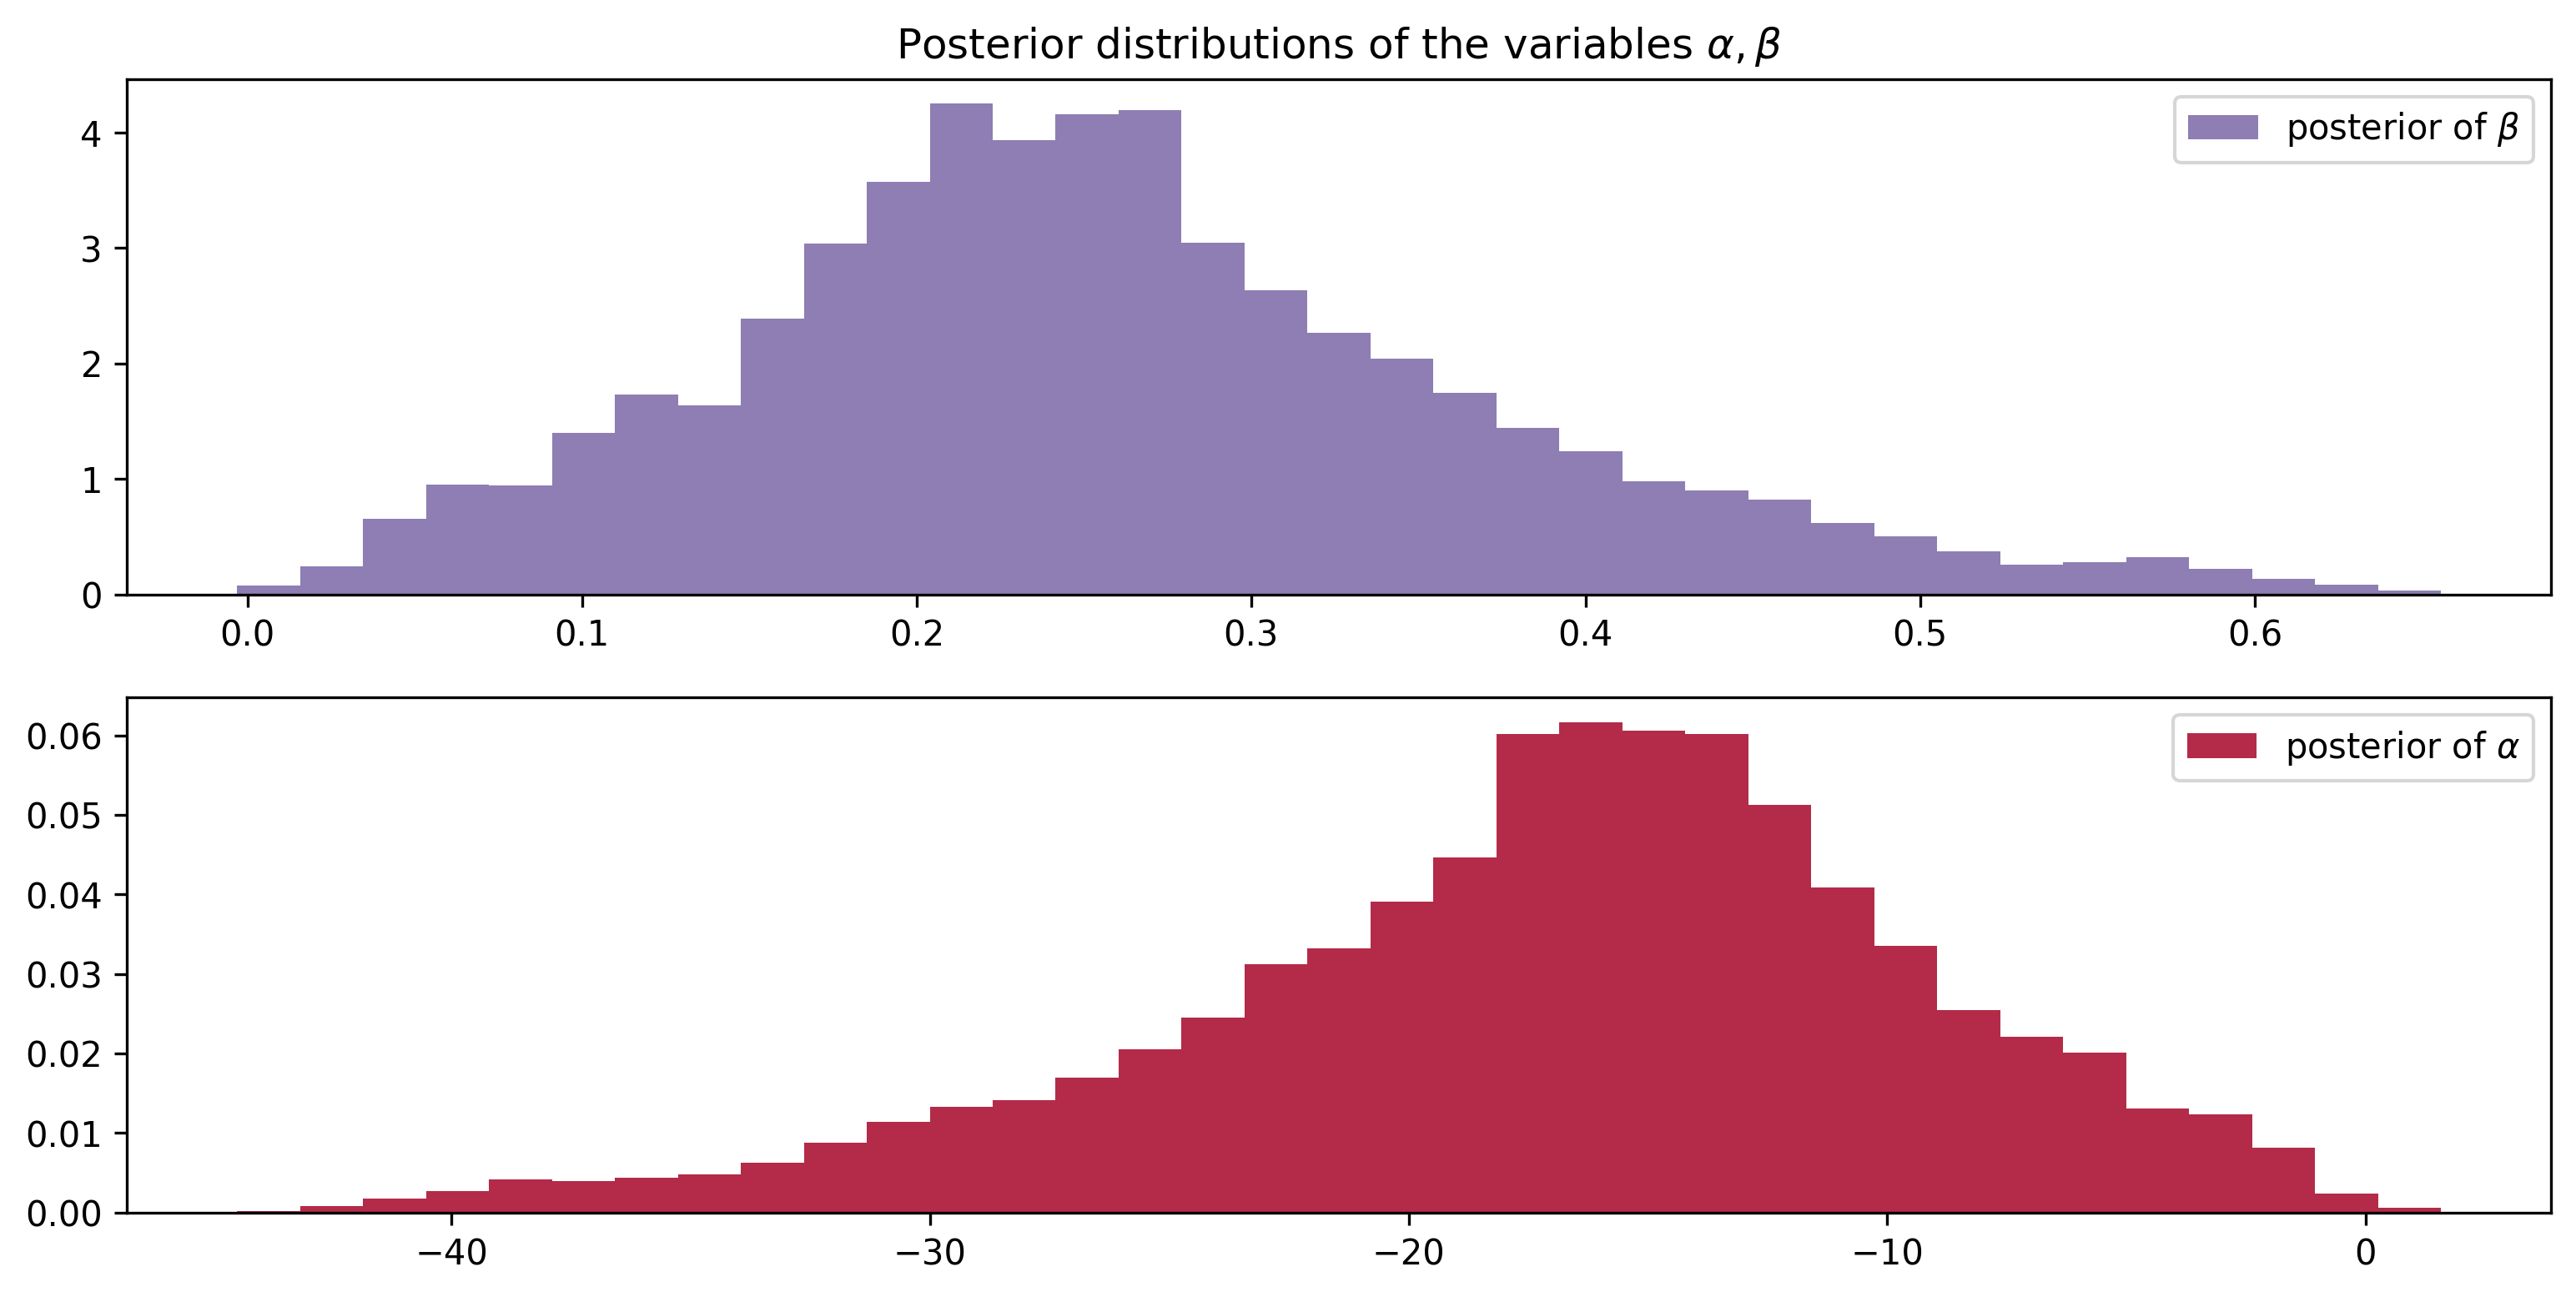

In [13]:
alpha_samples = burned_trace["alpha"][:, None]  # best to make them 1d
beta_samples = burned_trace["beta"][:, None]

figsize(12.5, 6)

#histogram of the samples:
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#7A68A6", density=True)
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#A60628", density=True)
plt.legend();

In [14]:
t = np.linspace(temperature.min() - 5, temperature.max()+5, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)

mean_prob_t = p_t.mean(axis=0)

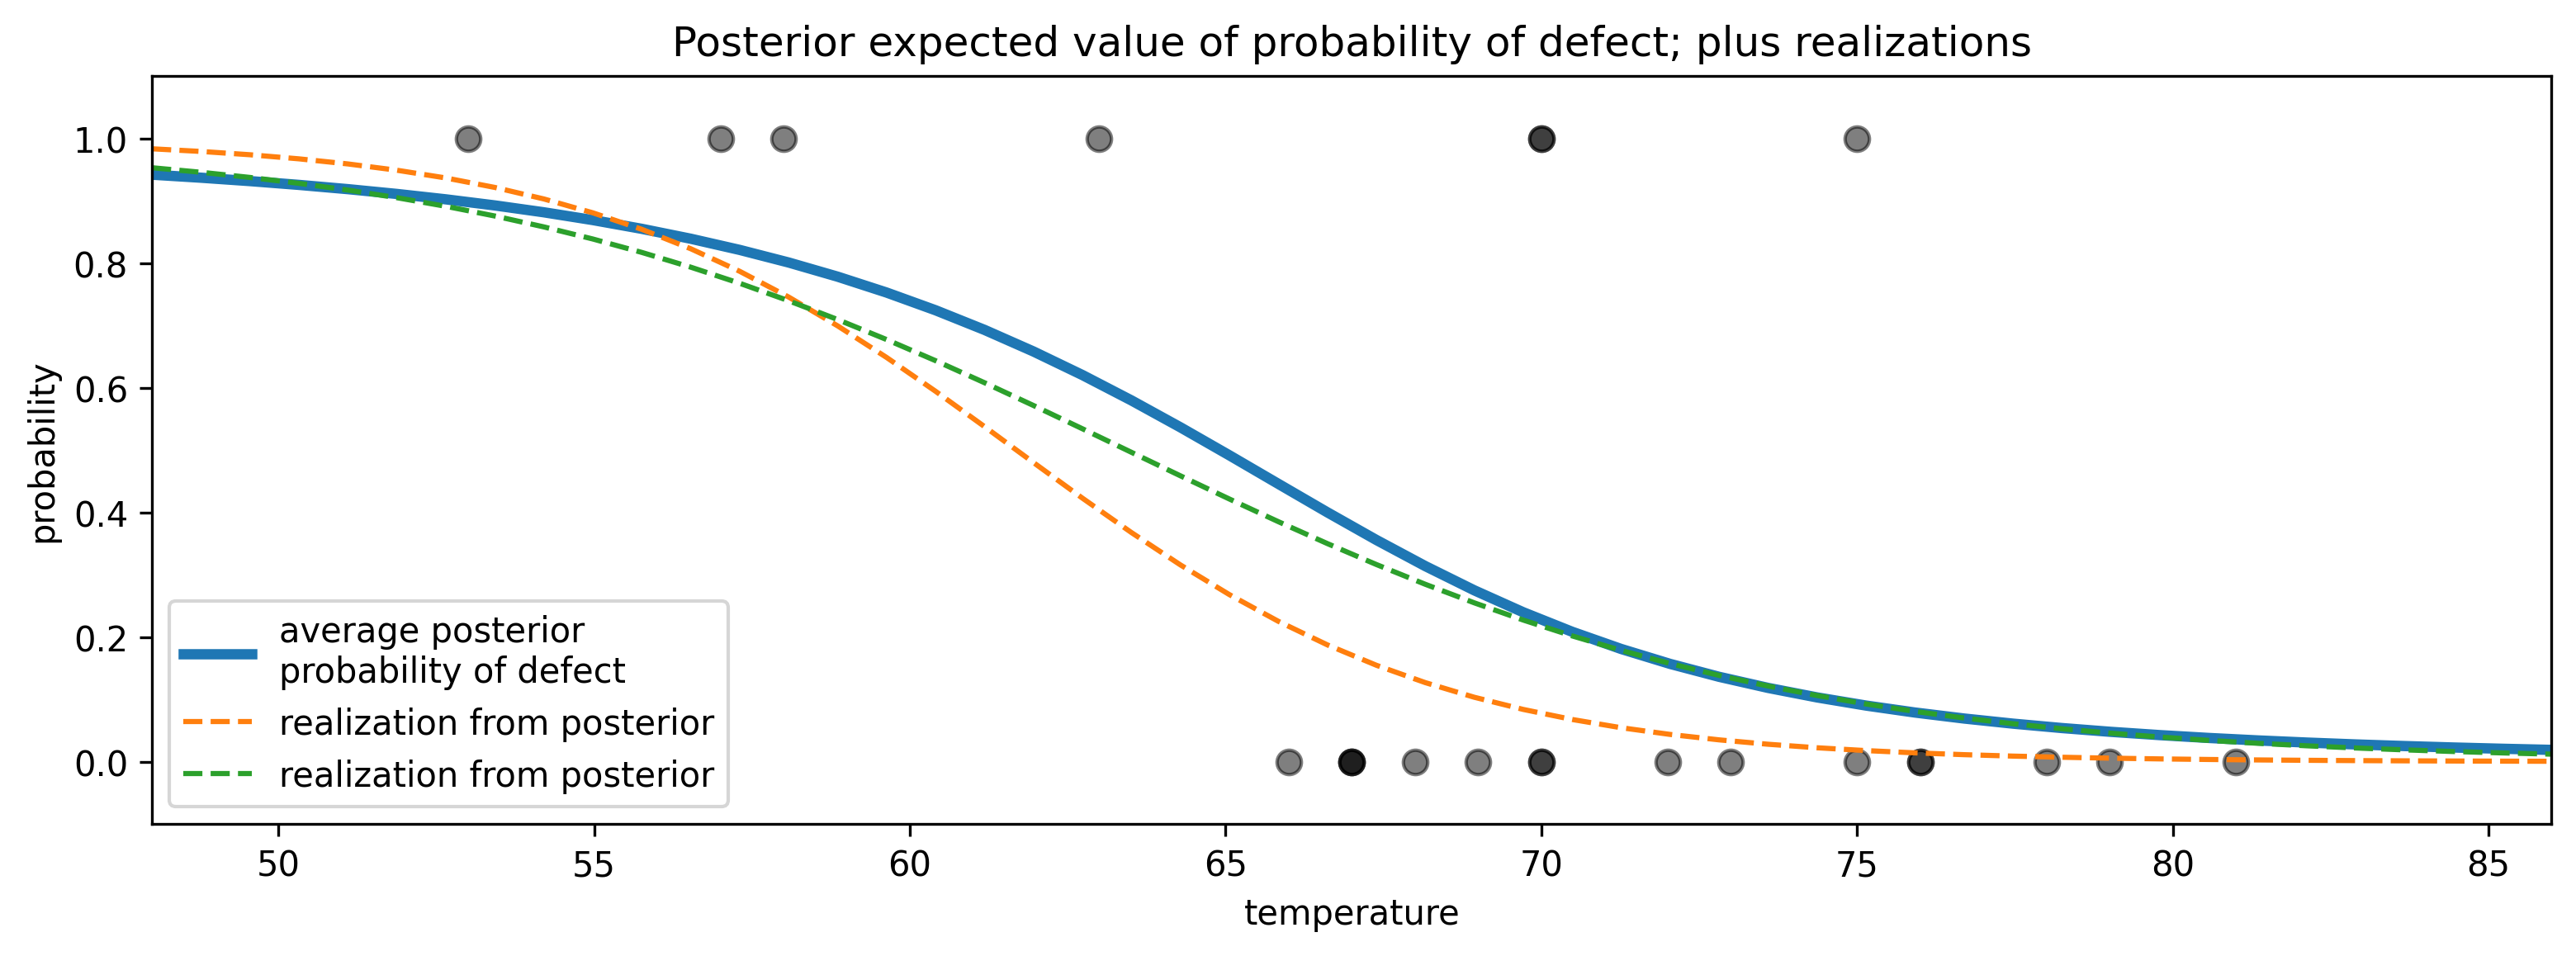

In [15]:
figsize(12.5, 4)

plt.plot(t, mean_prob_t, lw=3, label="average posterior \nprobability \
of defect")
plt.plot(t, p_t[0, :], ls="--", label="realization from posterior")
plt.plot(t, p_t[-2, :], ls="--", label="realization from posterior")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.title("Posterior expected value of probability of defect; \
plus realizations")
plt.legend(loc="lower left")
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("probability")
plt.xlabel("temperature");

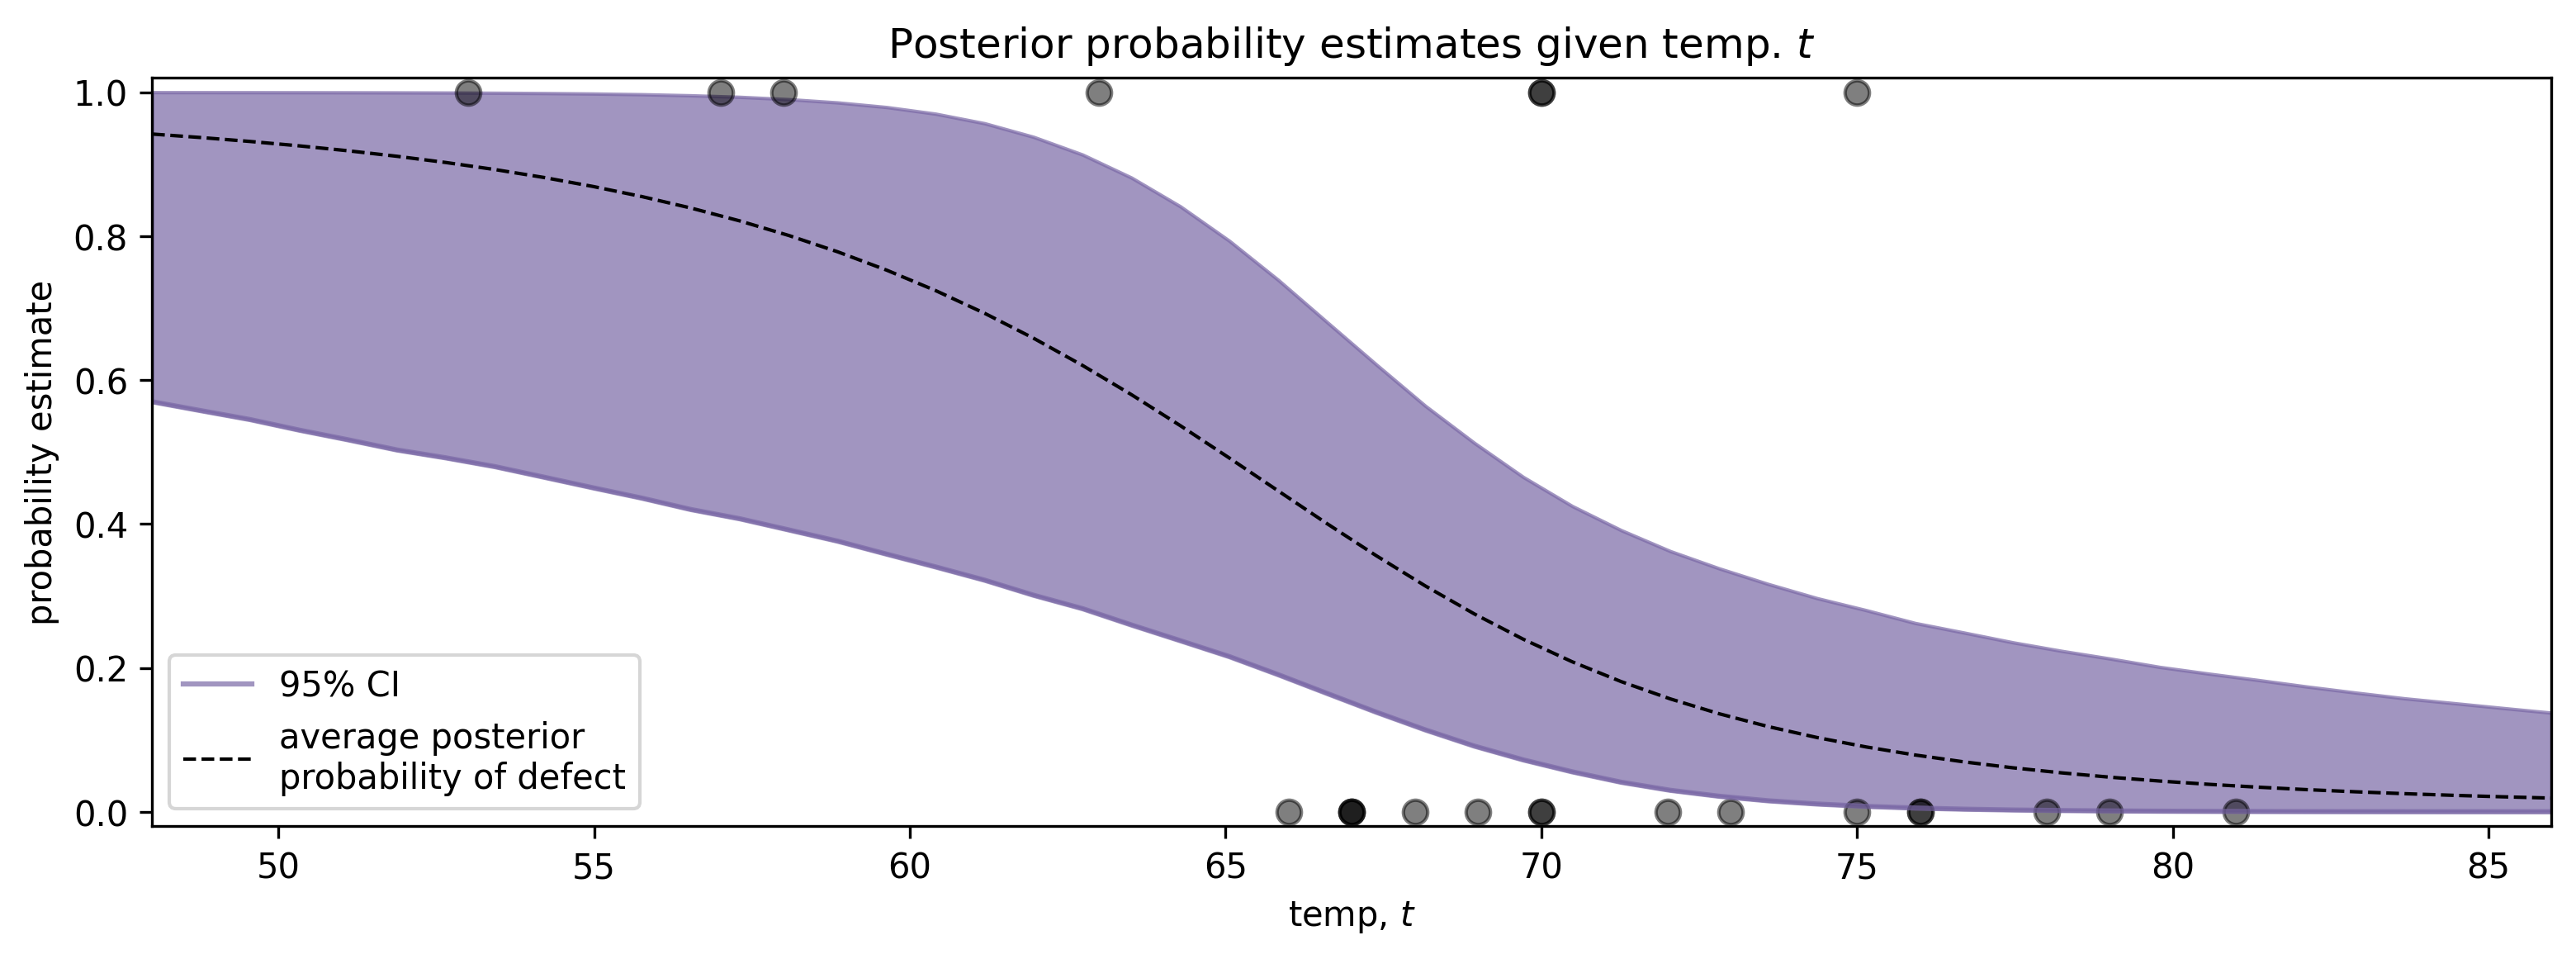

In [16]:
from scipy.stats.mstats import mquantiles

# vectorized bottom and top 2.5% quantiles for "confidence interval"
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=0.7,
                 color="#7A68A6")

plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="average posterior \nprobability of defect")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="lower left")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.xlabel("temp, $t$")

plt.ylabel("probability estimate")
plt.title("Posterior probability estimates given temp. $t$");

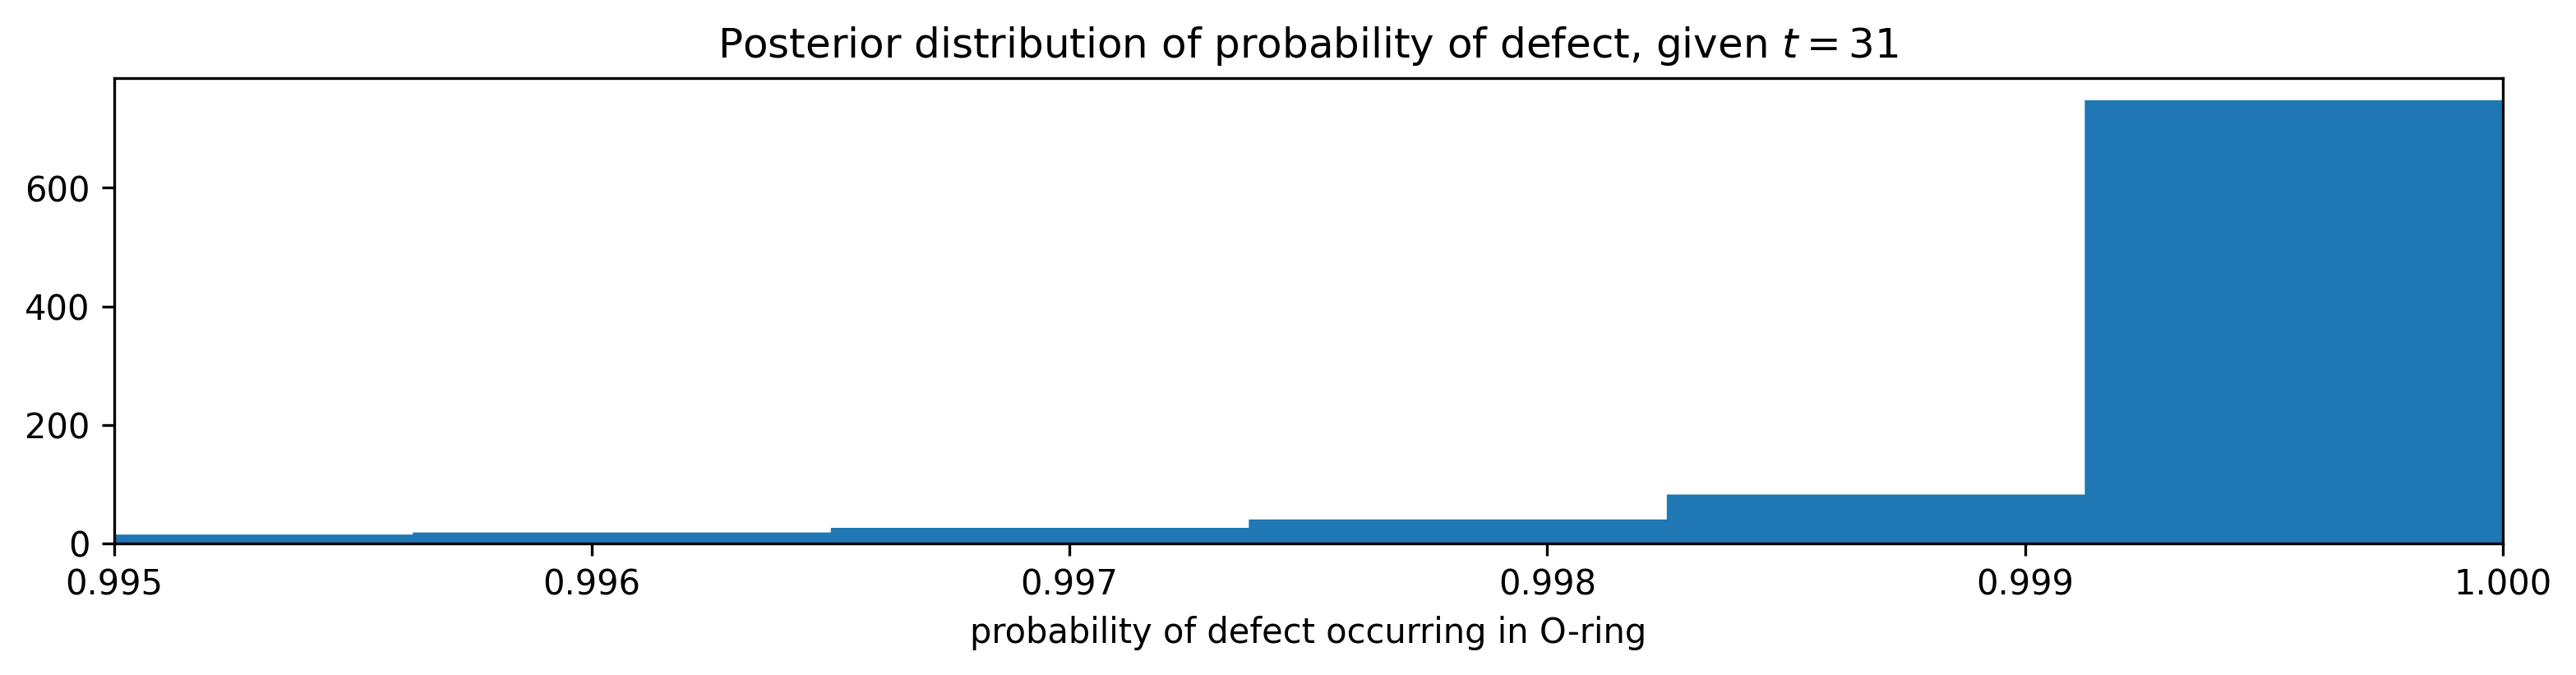

In [17]:
figsize(12.5, 2.5)

prob_31 = logistic(31, beta_samples, alpha_samples)

plt.xlim(0.995, 1)
plt.hist(prob_31, bins=1000, density=True, histtype='stepfilled')
plt.title("Posterior distribution of probability of defect, given $t = 31$")
plt.xlabel("probability of defect occurring in O-ring");